In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=1000)

In [3]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [4]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [5]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [6]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7,976.189651,-5653.417795,2770.480464
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2,-462.261129,-5535.146877,3120.593645
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3,-2256.980451,-3543.426543,4789.552023
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5,2410.348516,-5537.896973,2027.697745
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4,-350.359001,-5579.067584,3056.287693


In [7]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [8]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [9]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [10]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-10-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000


In [11]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [12]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-12-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000,NaN
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000,NaN
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219,NaN
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000,62.0
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000,NaN


In [13]:
# Define constants
KNOTS_TO_METERS_PER_SEC = 0.514444
df['sog_mps'] = df['SOG'].apply(lambda x: x * KNOTS_TO_METERS_PER_SEC)
df['cog_radians'] = df['COG'].apply(lambda x: np.radians(x))


In [14]:
df = df[['x','y','z','duration_seconds','distance_km','sog_mps','cog_radians']]

In [15]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
0,978.775466,-5636.091653,2804.658708,NaN,0.000000,0.051444,3.848451
1,-2409.574733,-3746.291746,4555.094813,NaN,0.000000,0.000000,3.813544
2,985.603053,-5636.104757,2802.240317,NaN,0.563219,14.558765,4.757768
3,985.048333,-5636.202230,2802.239319,62.0,0.000000,7.665216,4.701917
4,977.761677,-5441.347041,3166.285755,NaN,0.000000,5.453106,3.246312


In [16]:
df.dropna(inplace=True)

<ipython-input-16-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [17]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
3,985.048333,-5636.202230,2802.239319,62.0,0.0,7.665216,4.701917
8,1038.813807,-5617.560112,2820.199507,66.0,0.0,7.459438,0.713840
28,964.816679,-5298.686551,3403.335218,69.0,0.0,5.813217,4.066617
32,945.221036,-5275.068348,3445.265174,69.0,0.0,6.173328,2.089159
48,1043.049048,-5653.562549,2745.709415,61.0,0.0,6.276217,3.267256


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


# Convert cumulative duration to timestamps
df["timestamp"] = pd.to_datetime(df["duration_seconds"].cumsum(), unit="s")
df.set_index("timestamp", inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convert data to sequences for GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Use past 10 timesteps to predict next step
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [19]:
X_train.shape,y_train.shape

((86, 10, 7), (86, 7))

In [20]:
# Build GRU Model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    GRU(32, return_sequences=False),
    Dense(X.shape[2])  # Output layer with same number of features
])

model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          14,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,655 (92.40 KB)

 Trainable params: 23,655 (92.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.1087 - loss: 0.2847 - val_accuracy: 0.3182 - val_loss: 0.1546
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6229 - loss: 0.1070 - val_accuracy: 0.6818 - val_loss: 0.0898
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7119 - loss: 0.0659 - val_accuracy: 0.6818 - val_loss: 0.0674
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7207 - loss: 0.0614 - val_accuracy: 0.6818 - val_loss: 0.0707
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6874 - loss: 0.0597 - val_accuracy: 0.6818 - val_loss: 0.0746
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6478 - loss: 0.0545 - val_accuracy: 0.6818 - val_loss: 0.0719
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6624 - loss: 0.0543 - val_accuracy: 0.6818 - val_loss: 0.0666
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6082 - loss: 0.0522 - val_accuracy: 0.6818 - val_loss: 0.0626

In [21]:
# Predict next 10 steps
future_steps = 10
future_predictions = []

# Start with last observed sequence
input_seq = X_test[-1].reshape(1, seq_length, X.shape[2])

for _ in range(future_steps):
    pred = model.predict(input_seq)
    future_predictions.append(pred[0])  # Store prediction
    input_seq = np.roll(input_seq, -1, axis=1)  # Shift sequence
    input_seq[0, -1, :] = pred  # Append new prediction

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Create timestamp index for predictions
future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]
forecast_df = pd.DataFrame(future_predictions, columns=df.columns, index=future_timestamps)

print(forecast_df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
                              x            y            z  duration_seconds  \
1970-01-01 02:08:00 -942.620086 -4506.304866  3681.206056         58.625343   
1970-01-01 02:09:00 -925.326213 -4552.723469  3731.159839         59.634768   
1970-01-01 02:10:00 -923.863782 -4568.889010  3776.031453         60.423749   
1970-01-01 02:11:00 -898.198022 -4584.049656  3797.550396         61.040078   
1970-01-01 02:12:00 -889.470642 -4571.374719  3821.045709         61.239741   

                     distance_km   sog_mps  cog_radians  
1970-01-01 02:08:00     1.658039  4.332738     2.817252  
1970-01-01 02:09:00     1.36

<ipython-input-21-c59974a9c509>:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]


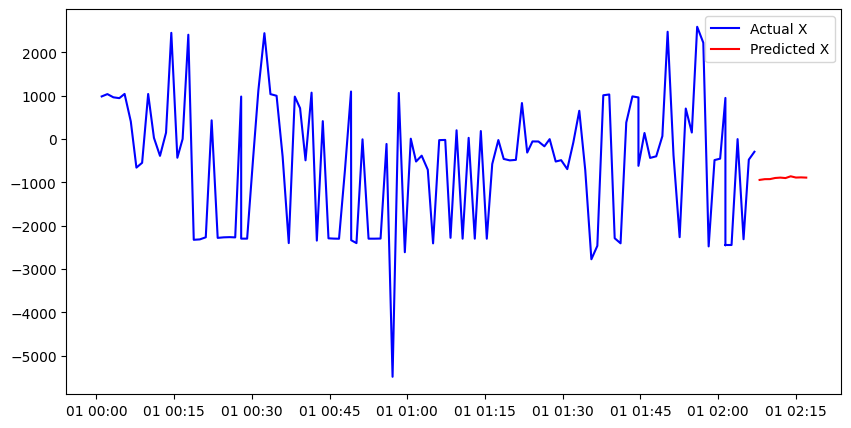

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["x"], label="Actual X", color="blue")
plt.plot(forecast_df.index, forecast_df["x"], label="Predicted X", color="red")
plt.legend()
plt.show()


# by adding absolute postinal encoding

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam


# Convert duration to timestamps
df["timestamp"] = pd.to_datetime(df["duration_seconds"].cumsum(), unit="s")
df.set_index("timestamp", inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Function to create absolute positional encoding
def positional_encoding(seq_length, feature_dim):
    """ Generate absolute positional encoding using sine and cosine functions. """
    pos_enc = np.zeros((seq_length, feature_dim))
    for i in range(seq_length):
        for j in range(0, feature_dim, 2):  # Even indices use sine, odd use cosine
            pos_enc[i, j] = np.sin(i / (10000 ** (j / feature_dim)))
            if j + 1 < feature_dim:
                pos_enc[i, j + 1] = np.cos(i / (10000 ** (j / feature_dim)))
    return pos_enc

# Function to add positional encoding to data sequences
def create_sequences_with_positional_encoding(data, seq_length):
    X, y = [], []
    pos_enc = positional_encoding(seq_length, data.shape[1])  # Compute position encodings
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        seq += pos_enc  # Add position encoding
        X.append(seq)
        y.append(data[i+seq_length])  # Next timestep target
    return np.array(X), np.array(y)

seq_length = 10  # Number of past time steps to use
X, y = create_sequences_with_positional_encoding(scaled_data, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [24]:
# Define GRU model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    GRU(32, return_sequences=False),
    Dense(X.shape[2])  # Output layer with same number of features
])

# Compile model with learning rate
lr = 0.01  # Experiment with lower or higher values
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss="mse", metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.4881 - loss: 21.7772 - val_accuracy: 0.6818 - val_loss: 6.1770
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4046 - loss: 7.4774 - val_accuracy: 0.6818 - val_loss: 3.9718
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3813 - loss: 3.0065 - val_accuracy: 0.6818 - val_loss: 4.0083
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4430 - loss: 0.9813 - val_accuracy: 0.6818 - val_loss: 4.7066
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3961 - loss: 0.1832 - val_accuracy: 0.6818 - val_loss: 5.6094
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3845 - loss: 0.1394 - val_accuracy: 0.6818 - val_loss: 6.2374
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4054 - loss: 0.2719 - val_accuracy: 0.3182 - val_loss: 6.2409
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5573 - loss: 0.2191 - val_accuracy: 0.3182 - val_loss: 5.8529
Epoch 9/5

In [25]:
# Predict next 10 steps
future_steps = 10
future_predictions = []

# Start with last observed sequence
input_seq = X_test[-1].reshape(1, seq_length, X.shape[2])

for _ in range(future_steps):
    pred = model.predict(input_seq)
    future_predictions.append(pred[0])  # Store prediction
    input_seq = np.roll(input_seq, -1, axis=1)  # Shift sequence
    input_seq[0, -1, :] = pred  # Append new prediction

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Create timestamp index for predictions
future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]
forecast_df = pd.DataFrame(future_predictions, columns=df.columns, index=future_timestamps)

print(forecast_df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
                                x            y             z  \
1970-01-01 02:08:00  15116.336129 -3160.470570  12711.363569   
1970-01-01 02:09:00  15118.866000 -3158.363793  12710.970602   
1970-01-01 02:10:00  15119.002802 -3158.215021  12711.000669   
1970-01-01 02:11:00  15119.313014 -3158.000460  12711.026541   
1970-01-01 02:12:00  15120.039413 -3157.531438  12711.061502   

                     duration_seconds  distance_km     sog_mps  cog_radians  
1970-01-01 02:08:00        733.512360    10.332708  120.007728     2.917216  
1970-01-01 02:09:00        733.558022    10.331578  120.022199     2.920655  


<ipython-input-25-c59974a9c509>:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]


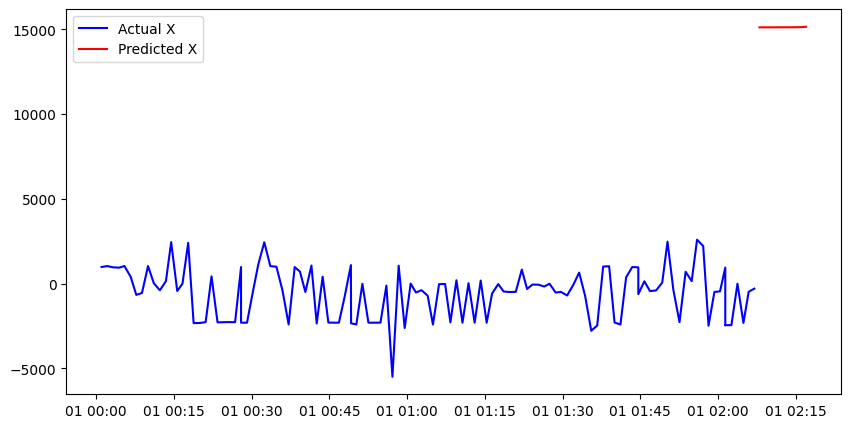

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["x"], label="Actual X", color="blue")
plt.plot(forecast_df.index, forecast_df["x"], label="Predicted X", color="red")
plt.legend()
plt.show()


# by using multi head attention + encoder

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Convert duration to timestamps
df["timestamp"] = pd.to_datetime(df["duration_seconds"].cumsum(), unit="s")
df.set_index("timestamp", inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Function to create time-series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Look at last 10 time steps
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]



# Define Transformer Encoder Block
def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    # Multi-Head Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)  # Residual connection

    # Feed-Forward Layer
    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    # Layer Normalization
    return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# Define Transformer Model for Time Series
def build_transformer_model(input_shape, num_heads=4, ff_dim=64):
    inputs = Input(shape=input_shape)

    # Transformer Encoder Blocks (Stacked)
    x = transformer_encoder(inputs, num_heads, ff_dim)
    x = transformer_encoder(x, num_heads, ff_dim)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(input_shape[1])(x)  # Predicting all features

    # Build Model
    model = Model(inputs, outputs)
    return model

# Build the Transformer Model
model = build_transformer_model((seq_length, X.shape[2]), num_heads=4, ff_dim=64)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse",metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0378 - loss: 1.0916 - val_accuracy: 0.5455 - val_loss: 0.4532
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4474 - loss: 0.3673 - val_accuracy: 0.5455 - val_loss: 0.2232
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4500 - loss: 0.1894 - val_accuracy: 0.6818 - val_loss: 0.1520
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6394 - loss: 0.1372 - val_accuracy: 0.6818 - val_loss: 0.1232
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4608 - loss: 0.0937 - val_accuracy: 0.4545 - val_loss: 0.0986
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4353 - loss: 0.0883 - val_accuracy: 0.6818 - val_loss: 0.0801
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6091 - loss: 0.0781 - val_accuracy: 0.6818 - val_loss: 0.0762
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5744 - loss: 0.0780 - val_accuracy: 0.6818 - val_loss: 0.0757

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


<ipython-input-29-d93760d47691>:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]


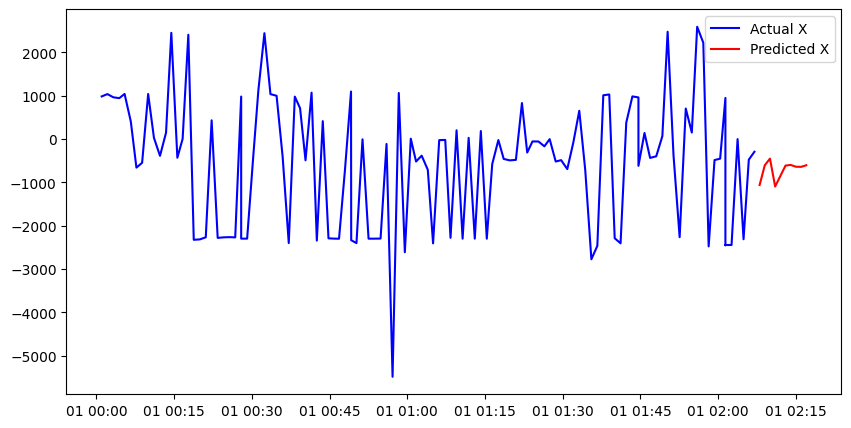

In [29]:
# Predict next 10 steps
future_steps = 10
future_predictions = []

# Start with last observed sequence
input_seq = X_test[-1].reshape(1, seq_length, X.shape[2])

for _ in range(future_steps):
    pred = model.predict(input_seq)
    future_predictions.append(pred[0])  # Store prediction
    input_seq = np.roll(input_seq, -1, axis=1)  # Shift sequence
    input_seq[0, -1, :] = pred  # Append new prediction

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Create timestamp index for predictions
future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]
forecast_df = pd.DataFrame(future_predictions, columns=df.columns, index=future_timestamps)

# Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["x"], label="Actual X", color="blue")
plt.plot(forecast_df.index, forecast_df["x"], label="Predicted X", color="red")
plt.legend()
plt.show()


# cnn

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



# Convert duration to timestamps
df["timestamp"] = pd.to_datetime(df["duration_seconds"].cumsum(), unit="s")
df.set_index("timestamp", inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Function to create time-series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Look at last 10 time steps
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]



In [32]:
# Define Hybrid CNN + LSTM Model
def build_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # Feature extraction using Conv1D
    x = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(inputs)
    x = Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(x)

    # LSTM for sequence modeling
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32, return_sequences=False)(x)

    # Fully Connected Layer
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(input_shape[1])(x)  # Predicting all features

    # Build Model
    model = Model(inputs, outputs)
    return model

# Build the CNN + LSTM Model
model = build_cnn_lstm_model((seq_length, X.shape[2]))

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.2707 - loss: 0.2541 - val_accuracy: 0.1818 - val_loss: 0.1179
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2781 - loss: 0.1279 - val_accuracy: 0.6818 - val_loss: 0.0730
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4013 - loss: 0.1187 - val_accuracy: 0.6818 - val_loss: 0.0694
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5819 - loss: 0.0938 - val_accuracy: 0.6818 - val_loss: 0.0718
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5018 - loss: 0.0875 - val_accuracy: 0.6818 - val_loss: 0.0696
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4399 - loss: 0.0870 - val_accuracy: 0.6818 - val_loss: 0.0762
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4922 - loss: 0.0711 - val_accuracy: 0.6818 - val_loss: 0.0705
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5817 - loss: 0.0786 - val_accuracy: 0.6818 - val_loss: 0.0662

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<ipython-input-33-d93760d47691>:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]


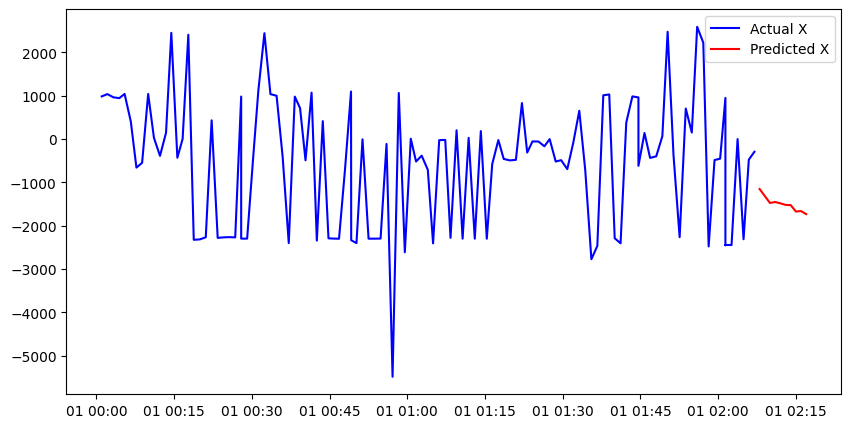

In [33]:
# Predict next 10 steps
future_steps = 10
future_predictions = []

# Start with last observed sequence
input_seq = X_test[-1].reshape(1, seq_length, X.shape[2])

for _ in range(future_steps):
    pred = model.predict(input_seq)
    future_predictions.append(pred[0])  # Store prediction
    input_seq = np.roll(input_seq, -1, axis=1)  # Shift sequence
    input_seq[0, -1, :] = pred  # Append new prediction

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Create timestamp index for predictions
future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]
forecast_df = pd.DataFrame(future_predictions, columns=df.columns, index=future_timestamps)

# Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["x"], label="Actual X", color="blue")
plt.plot(forecast_df.index, forecast_df["x"], label="Predicted X", color="red")
plt.legend()
plt.show()


# attention (en+de)

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Convert duration to timestamps
df["timestamp"] = pd.to_datetime(df["duration_seconds"].cumsum(), unit="s")
df.set_index("timestamp", inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Function to create time-series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Look at last 10 time steps
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]



In [35]:
def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    # Multi-Head Self Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)  # Residual Connection

    # Feed-Forward Layer
    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    # Final Layer Normalization
    return LayerNormalization(epsilon=1e-6)(attention + ff_output)
def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    # Self-Attention (Masking Future Timesteps)
    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention1 = Dropout(dropout_rate)(attention1)
    attention1 = LayerNormalization(epsilon=1e-6)(inputs + attention1)

    # Cross-Attention with Encoder Output
    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(attention1, encoder_outputs)
    attention2 = Dropout(dropout_rate)(attention2)
    attention2 = LayerNormalization(epsilon=1e-6)(attention1 + attention2)

    # Feed-Forward Layer
    ff_output = Dense(ff_dim, activation="relu")(attention2)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    # Final Layer Normalization
    return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)
def build_transformer_model(input_shape, num_heads=4, ff_dim=64):
    # Encoder Input
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    encoder_outputs = transformer_encoder(encoder_inputs, num_heads, ff_dim)
    encoder_outputs = transformer_encoder(encoder_outputs, num_heads, ff_dim)  # Stack 2 Encoders

    # Decoder Input (Last known time step)
    decoder_inputs = Input(shape=input_shape, name="decoder_inputs")
    decoder_outputs = transformer_decoder(decoder_inputs, encoder_outputs, num_heads, ff_dim)
    decoder_outputs = transformer_decoder(decoder_outputs, encoder_outputs, num_heads, ff_dim)  # Stack 2 Decoders

    # Output Layer
    x = Flatten()(decoder_outputs)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(input_shape[1])(x)  # Predicting all features

    # Build Model
    model = Model([encoder_inputs, decoder_inputs], outputs)
    return model

# Build Transformer Model
model = build_transformer_model((seq_length, X.shape[2]), num_heads=4, ff_dim=64)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])

# Train Model
history = model.fit([X_train, X_train], y_train, epochs=50, batch_size=16, validation_data=([X_test, X_test], y_test))


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - accuracy: 0.0483 - loss: 1.0011 - val_accuracy: 0.1818 - val_loss: 0.1256
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4035 - loss: 0.0950 - val_accuracy: 0.6364 - val_loss: 0.0937
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6019 - loss: 0.0859 - val_accuracy: 0.6364 - val_loss: 0.0830
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5215 - loss: 0.0713 - val_accuracy: 0.6364 - val_loss: 0.0776
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4878 - loss: 0.0712 - val_accuracy: 0.6818 - val_loss: 0.0718
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5054 - loss: 0.0727 - val_accuracy: 0.6818 - val_loss: 0.0703
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5476 - loss: 0.0703 - val_accuracy: 0.6818 - val_loss: 0.0714
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7005 - loss: 0.0600 - val_accuracy: 0.6818 - val_loss: 0.076

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<ipython-input-36-e43ca749e42e>:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]


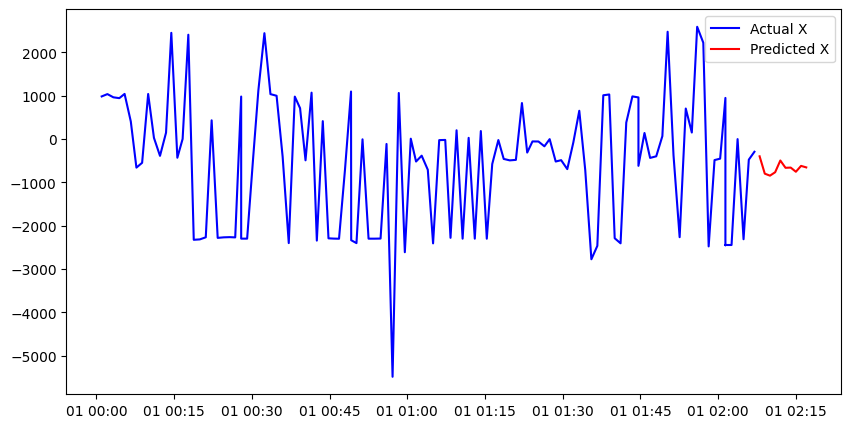

In [36]:
# Predict next 10 steps
future_steps = 10
future_predictions = []

# Start with last observed sequence
input_seq = X_test[-1].reshape(1, seq_length, X.shape[2])

for _ in range(future_steps):
    pred = model.predict([input_seq, input_seq])
    future_predictions.append(pred[0])  # Store prediction
    input_seq = np.roll(input_seq, -1, axis=1)  # Shift sequence
    input_seq[0, -1, :] = pred  # Append new prediction

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Create timestamp index for predictions
future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]
forecast_df = pd.DataFrame(future_predictions, columns=df.columns, index=future_timestamps)

# Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["x"], label="Actual X", color="blue")
plt.plot(forecast_df.index, forecast_df["x"], label="Predicted X", color="red")
plt.legend()
plt.show()
